**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Working with Data](#toc2_)    
- [Transformers](#toc3_)    
  - [Series2Series](#toc3_1_)    
    - [StandardScalerTransformer](#toc3_1_1_)    
    - [DifferenceNormalizer](#toc3_1_2_)    
    - [TimeToNumGenerator & DateSeasonsGenerator](#toc3_1_3_)    
    - [LabelEncodingTransformer & OneHotEncodingTransformer](#toc3_1_4_)    
    - [MissingValuesImputer](#toc3_1_5_)    
  - [Series2Features](#toc3_2_)    
    - [LagTransformer & TargetGenerator](#toc3_2_1_)    
  - [Features2Features](#toc3_3_)    
    - [LastKnownNormalizer](#toc3_3_1_)    
  - [Sequential & Union](#toc3_4_)    
- [Pipeline](#toc4_)    
      - [Can I use exogenous variables in the pipeline?](#toc4_1_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

In this tutorial, we will take a closer look at the transformers available in the tsururu library and delve into how to initialize the `Pipeline` class.
We will explore how transformers affect the feature generation process used for model training.

In [1]:
import warnings

warnings.filterwarnings("ignore")

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tsururu.dataset import IndexSlicer, Pipeline, TSDataset
from tsururu.transformers import (
    DateSeasonsGenerator,
    DifferenceNormalizer,
    LabelEncodingTransformer,
    LagTransformer,
    LastKnownNormalizer,
    MissingValuesImputer,
    OneHotEncodingTransformer,
    SequentialTransformer,
    StandardScalerTransformer,
    TargetGenerator,
    TimeToNumGenerator,
    UnionTransformer,
)

In [2]:
index_slicer = IndexSlicer()  # Class to create indices for the dataset

horizon = 3
history = 10

# <a id='toc2_'></a>[Working with Data](#toc0_)

To illustrate, we will use a simple setup with two time series and progressively explore the available transformers, observing their impact on the data.

In [3]:
df = pd.read_csv("../datasets/global/demand_forecasting_kernels.csv")
df = df[(df["id"] == 0) | (df["id"] == 1)]

dataset_params = {
    "target": {
        "columns": ["value"],
        "type": "continuous",
    },
    "date": {
        "columns": ["date"],
        "type": "datetime",
    },
    "id": {
        "columns": ["id"],
        "type": "categorical",
    }
}

df

,date,value,id
0,2013-01-01,48,0
1,2013-01-02,44,0
2,2013-01-03,60,0
3,2013-01-04,56,0
4,2013-01-05,50,0
...,...,...,...
3647,2017-12-27,14,1
3648,2017-12-28,19,1
3649,2017-12-29,15,1
3650,2017-12-30,27,1


In [4]:
dataset = TSDataset(
    data=df,
    columns_params=dataset_params,
    print_freq_period_info=True,
)

freq: Day; period: 1


Transformers work with data presented in a dictionary format, which contains:

**raw_ts_X** and **raw_ts_y**:
- These are the original "long" time series copied from the dataset. They contain all available data, including columns like `id`, `date`, `target`, as well as exogenous and generated features.

**X** and **y**:
- These are arrays that hold the generated features (X) and targets (y). Initially, they are empty but get populated as transformers are applied.

**id_column_name**, **date_column_name**, **target_column_name**:
- These are simply the column names.

**idx_X** and **idx_y**:
- These are indices that point to the available data for generating features and targets at each time point.
- Indices are external to the pipeline and are set or managed by the strategy.

In [5]:
features_idx = index_slicer.create_idx_data(
    dataset.data,
    horizon,
    history,
    step=1,
    date_column=dataset.date_column,
    delta=dataset.delta,
)

target_idx = index_slicer.create_idx_target(
    dataset.data,
    horizon,
    history,
    step=1,
    date_column=dataset.date_column,
    delta=dataset.delta,
)

data = Pipeline.create_data_dict_for_pipeline(dataset, features_idx, target_idx)

In [6]:
for key, value in data.items():
    print(key, end=": ")
    if isinstance(value, pd.DataFrame):
        display(value.head())
    elif isinstance(value, np.ndarray):
        print(value[:5])
    else:
        print(value)

raw_ts_X: 

,date,value,id
0,2013-01-01,48.0,0
1,2013-01-02,44.0,0
2,2013-01-03,60.0,0
3,2013-01-04,56.0,0
4,2013-01-05,50.0,0


raw_ts_y: 

,date,value,id
0,2013-01-01,48.0,0
1,2013-01-02,44.0,0
2,2013-01-03,60.0,0
3,2013-01-04,56.0,0
4,2013-01-05,50.0,0


X: []
y: []
id_column_name: id
date_column_name: date
target_column_name: value
num_series: 2
idx_X: [[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]]
idx_y: [[10 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]]


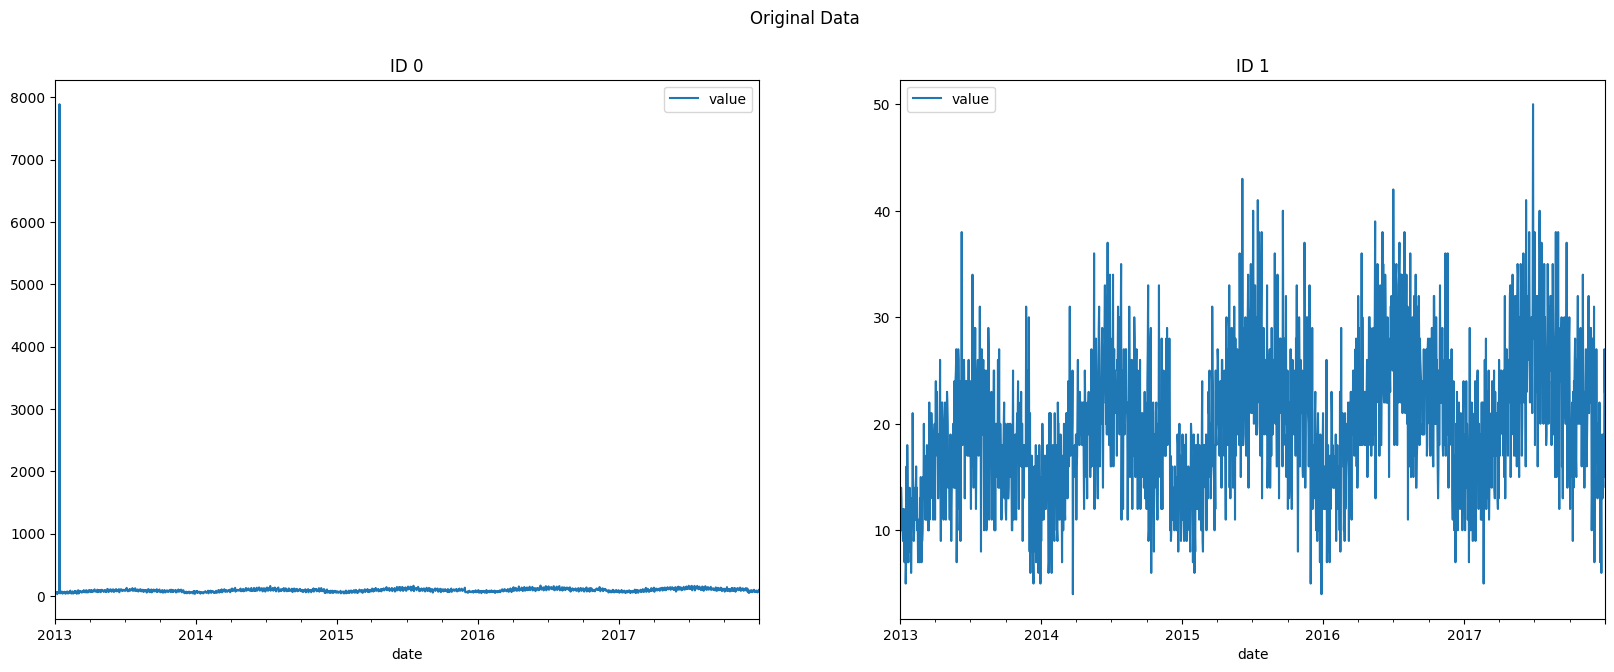

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

dataset.data[dataset.data["id"] == 0].plot(x=dataset.date_column, y=dataset.target_column, ax=ax[0])
dataset.data[dataset.data["id"] == 1].plot(x=dataset.date_column, y=dataset.target_column, ax=ax[1])

plt.suptitle("Original Data")
ax[0].set_title("ID 0")
ax[1].set_title("ID 1")

plt.legend()
plt.show()

# <a id='toc3_'></a>[Transformers](#toc0_)

In the process of working with time series, various types of transformers are used to handle data at different stages of transformation. In tsururu, transformers can be categorized into three types: Series2Series, Series2Features, and Features2Features.

## <a id='toc3_1_'></a>[Series2Series](#toc0_)

- These transformers work with the original “long” series.
- During the training phase, they add new columns to this long series. These can be new features derived from the existing data (such as in the case of date-related and id-related feature generators) or normalized values of the existing data.

### <a id='toc3_1_1_'></a>[StandardScalerTransformer](#toc0_)

`StandardScalerTransformer`: data normalization.



- The **transform_features** and **transform_target** parameters allow independent control over the normalization of features and targets. It may be beneficial, in terms of model performance, to normalize only the features while keeping the targets in their original scale, or vice versa.
- The **agg_by_id** parameter determines whether the normalization is applied separately for each time series with a unique id, or for all series together. For example, when normalizing date-related features, it is useful to set **agg_by_id=False**.

In [8]:
data = Pipeline.create_data_dict_for_pipeline(dataset, features_idx, target_idx)

scaler = StandardScalerTransformer(
    transform_features=True,
    transform_target=False,
    agg_by_id=True,
)

print("raw_ts_X before scaling:")
display(data["raw_ts_X"].head())

print("raw_ts_y before scaling:")
display(data["raw_ts_y"].head())

data = scaler.fit_transform(data, input_features=[dataset.target_column])

print("raw_ts_X after scaling:")
display(data["raw_ts_X"].head())

print("raw_ts_y after scaling:")
display(data["raw_ts_y"].head())

raw_ts_X before scaling:


,date,value,id
0,2013-01-01,48.0,0
1,2013-01-02,44.0,0
2,2013-01-03,60.0,0
3,2013-01-04,56.0,0
4,2013-01-05,50.0,0


raw_ts_y before scaling:


,date,value,id
0,2013-01-01,48.0,0
1,2013-01-02,44.0,0
2,2013-01-03,60.0,0
3,2013-01-04,56.0,0
4,2013-01-05,50.0,0


raw_ts_X after scaling:


,id,date,value,value__standard_scaler
0,0,2013-01-01,48.0,-0.254108
1,0,2013-01-02,44.0,-0.275840
2,0,2013-01-03,60.0,-0.188914
3,0,2013-01-04,56.0,-0.210645
4,0,2013-01-05,50.0,-0.243242


raw_ts_y after scaling:


,date,value,id,value__standard_scaler
0,2013-01-01,48.0,0,48.0
1,2013-01-02,44.0,0,44.0
2,2013-01-03,60.0,0,60.0
3,2013-01-04,56.0,0,56.0
4,2013-01-05,50.0,0,50.0


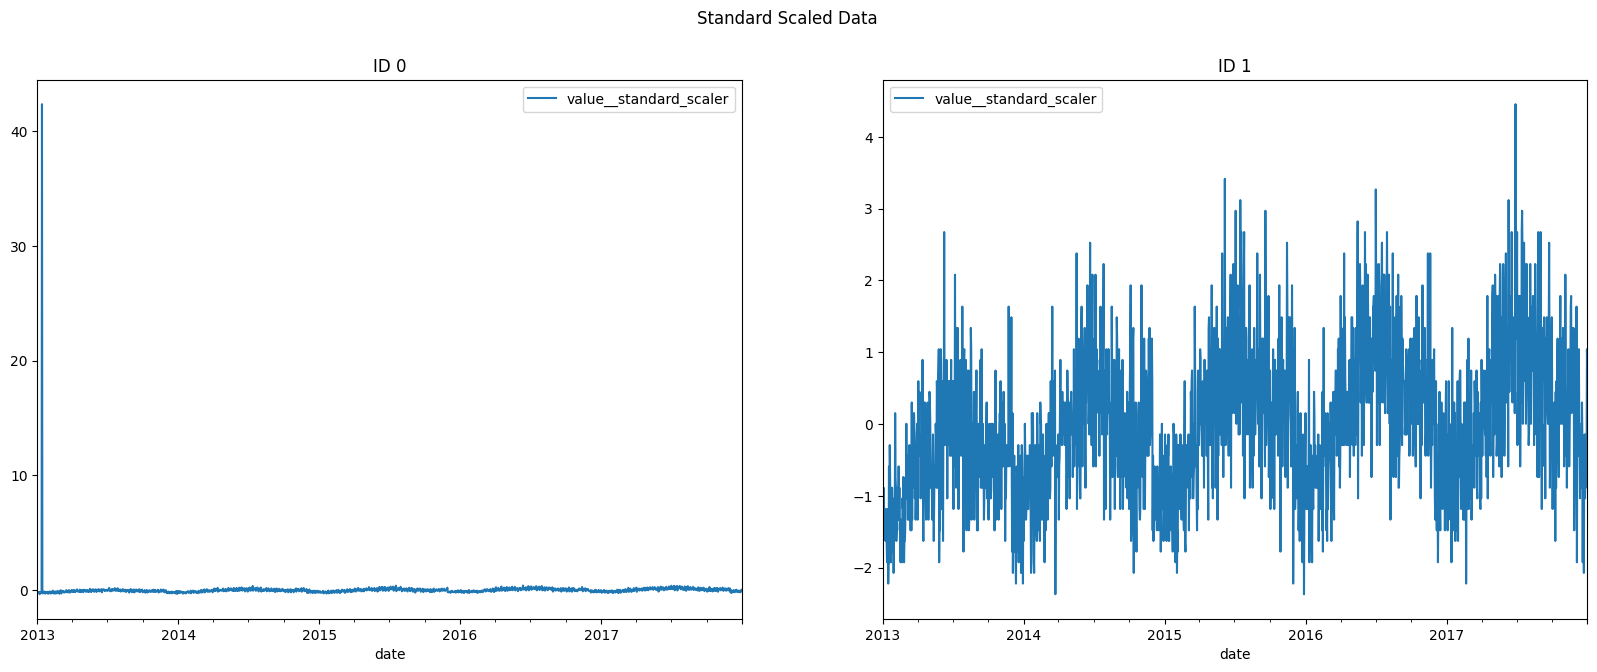

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

data["raw_ts_X"][data["raw_ts_X"]["id"] == 0].plot(
    x=dataset.date_column, y=f"{dataset.target_column}__standard_scaler", ax=ax[0]
)
data["raw_ts_X"][data["raw_ts_X"]["id"] == 1].plot(
    x=dataset.date_column, y=f"{dataset.target_column}__standard_scaler", ax=ax[1]
)

plt.suptitle("Standard Scaled Data")
ax[0].set_title("ID 0")
ax[1].set_title("ID 1")

plt.legend()
plt.show()

We can see that in **raw_ts_X**, the variable `value` has been normalized, while in **raw_ts_y** it remains unchanged.

### <a id='toc3_1_2_'></a>[DifferenceNormalizer](#toc0_)

`DifferenceNormalizer`: normalization by subtracting or dividing by previous values.

- The **transform_features** and **transform_target** parameters allow independent control over the normalization of features and targets. It may be beneficial, in terms of model performance, to normalize only the features while keeping the targets in their original scale, or vice versa.
- The **regime** parameter defines the method of normalization (either we divide by the previous value — **ratio**, or subtract the previous value from the current one — **delta**).

In [10]:
# Show both the delta and ratio regimes -> create new column with the same values
# For data[dataset.target_column] use the delta regime and for data[f"{dataset.target_column}_1"] use the ratio regime

dataset_copy = deepcopy(dataset)
dataset_copy.data[f"{dataset.target_column}_1"] = dataset_copy.data[dataset.target_column]

data = Pipeline.create_data_dict_for_pipeline(dataset_copy, features_idx, target_idx)

diff_delta = DifferenceNormalizer(
    transform_features=True,
    transform_target=True,  # Now let's transform the target too
    regime="delta"
)

diff_ratio = DifferenceNormalizer(
    transform_features=True,
    transform_target=False,
    regime="ratio"
)

print("raw_ts_X before differencing:")
display(data["raw_ts_X"].head())

print("raw_ts_y before differencing:")
display(data["raw_ts_y"].head())

data = diff_delta.fit_transform(data, input_features=[dataset.target_column])
data = diff_ratio.fit_transform(data, input_features=[f"{dataset.target_column}_1"])

print("raw_ts_X after differencing:")
display(data["raw_ts_X"].head())

print("raw_ts_y after differencing:")
display(data["raw_ts_y"].head())

raw_ts_X before differencing:


,date,value,id,value_1
0,2013-01-01,48.0,0,48.0
1,2013-01-02,44.0,0,44.0
2,2013-01-03,60.0,0,60.0
3,2013-01-04,56.0,0,56.0
4,2013-01-05,50.0,0,50.0


raw_ts_y before differencing:


,date,value,id,value_1
0,2013-01-01,48.0,0,48.0
1,2013-01-02,44.0,0,44.0
2,2013-01-03,60.0,0,60.0
3,2013-01-04,56.0,0,56.0
4,2013-01-05,50.0,0,50.0


raw_ts_X after differencing:


,id,date,value,value_1,value__diff_norm,value_1__diff_norm
0,0,2013-01-01,48.0,48.0,NaN,NaN
1,0,2013-01-02,44.0,44.0,-4.0,0.916667
2,0,2013-01-03,60.0,60.0,16.0,1.363636
3,0,2013-01-04,56.0,56.0,-4.0,0.933333
4,0,2013-01-05,50.0,50.0,-6.0,0.892857


raw_ts_y after differencing:


,id,date,value,value_1,value__diff_norm
0,0,2013-01-01,48.0,48.0,NaN
1,0,2013-01-02,44.0,44.0,-4.0
2,0,2013-01-03,60.0,60.0,16.0
3,0,2013-01-04,56.0,56.0,-4.0
4,0,2013-01-05,50.0,50.0,-6.0


We can see that after applying `DifferenceNormalizer`, missing values are generated. Therefore, if the base model cannot handle missing values, it is necessary to apply `MissingValuesImputer`.

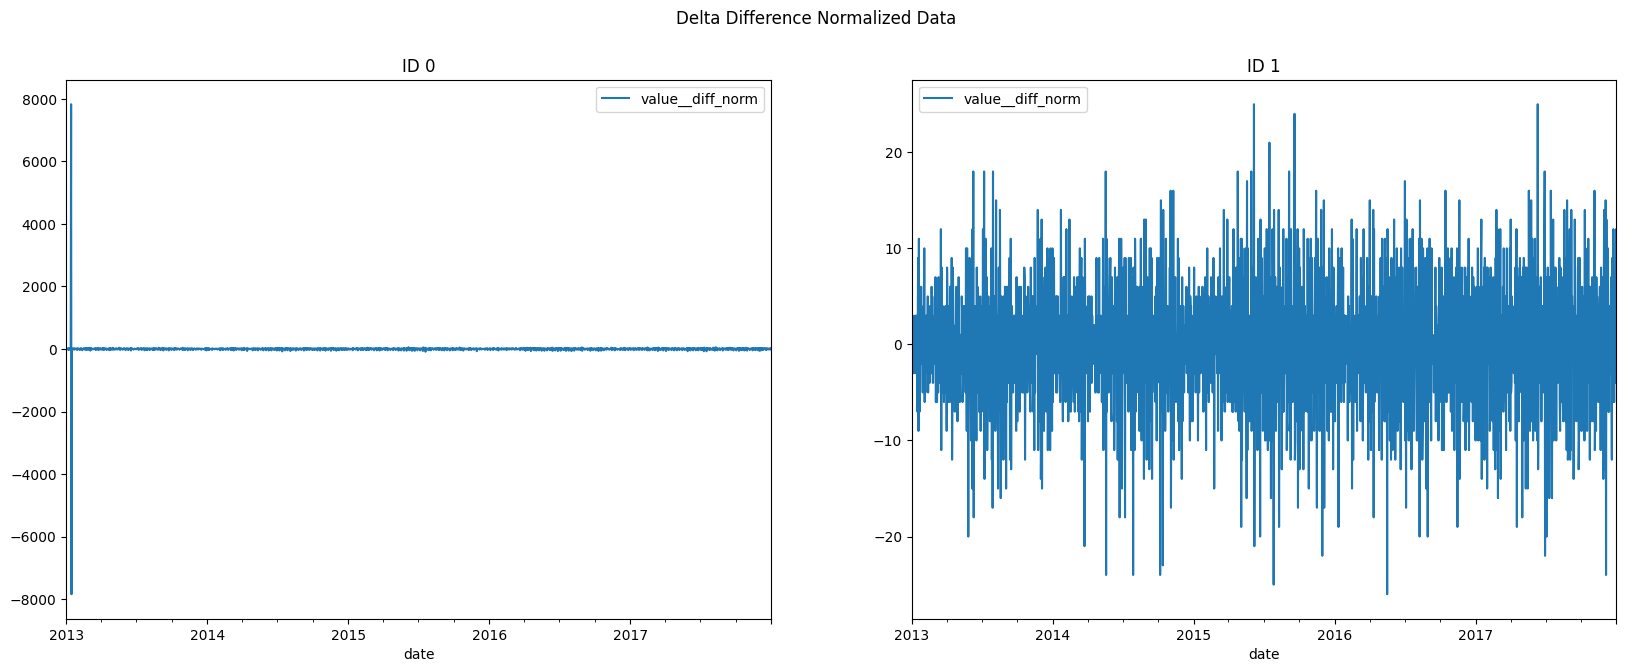

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

data["raw_ts_X"][data["raw_ts_X"]["id"] == 0].plot(
    x=dataset.date_column, y=f"{dataset.target_column}__diff_norm", ax=ax[0]
)
data["raw_ts_X"][data["raw_ts_X"]["id"] == 1].plot(
    x=dataset.date_column, y=f"{dataset.target_column}__diff_norm", ax=ax[1]
)

plt.suptitle("Delta Difference Normalized Data")
ax[0].set_title("ID 0")
ax[1].set_title("ID 1")

plt.legend()
plt.show()

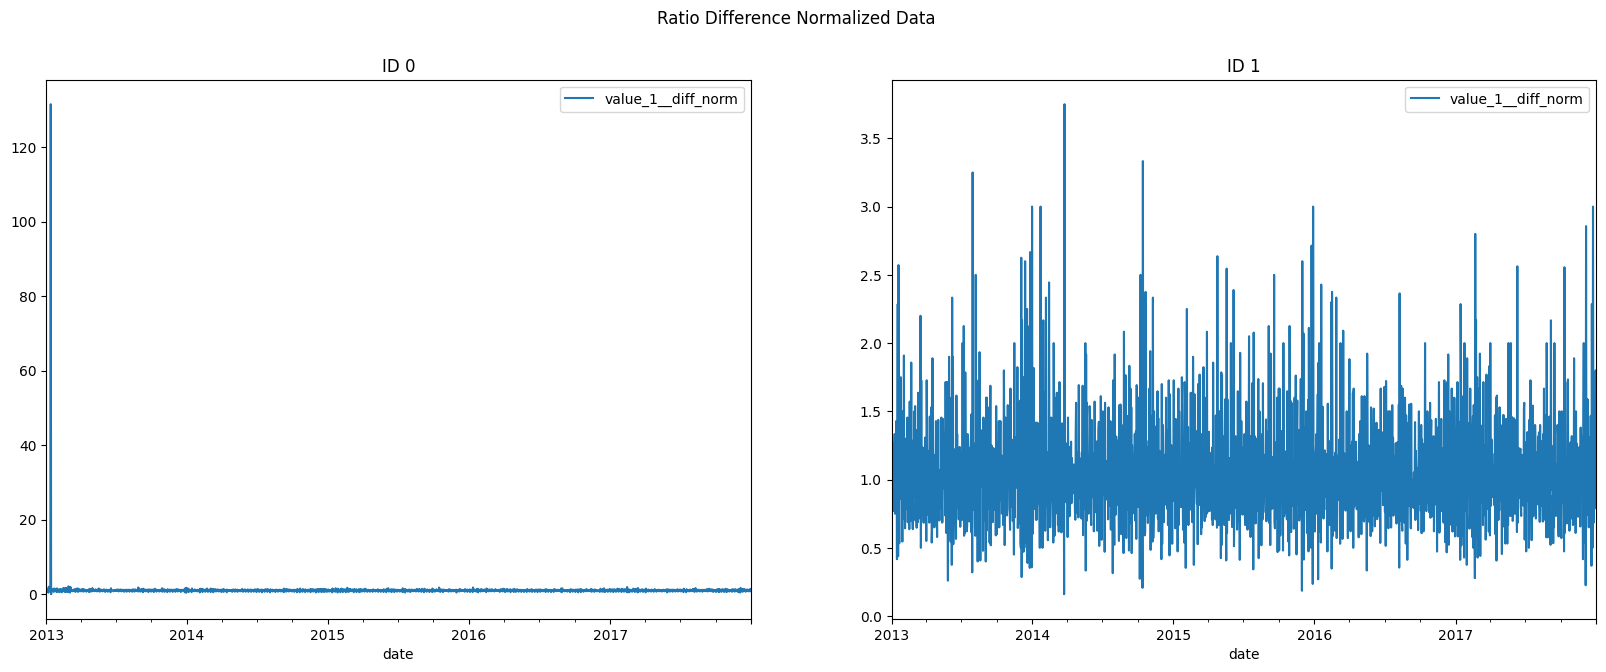

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

data["raw_ts_X"][data["raw_ts_X"]["id"] == 0].plot(
    x=dataset.date_column, y=f"{dataset.target_column}_1__diff_norm", ax=ax[0]
)
data["raw_ts_X"][data["raw_ts_X"]["id"] == 1].plot(
    x=dataset.date_column, y=f"{dataset.target_column}_1__diff_norm", ax=ax[1]
)

plt.suptitle("Ratio Difference Normalized Data")
ax[0].set_title("ID 0")
ax[1].set_title("ID 1")

plt.legend()
plt.show()

Let's import everything we need and define functions to obtain the results.

### <a id='toc3_1_3_'></a>[TimeToNumGenerator & DateSeasonsGenerator](#toc0_)

`TimeToNumGenerator`: converts timestamps into integer values.

- The **basic_date** parameter defines the base date from which calculations start.
- **from_target_date** specifies whether to use the last date from the forecasting horizon or the last date from the available history.
- Finally, you need to specify the **delta** parameter — the granularity of the series in string format.

`DateSeasonsGenerator`: generates seasonal features and holidays based on timestamps.

- The **seasonalities** parameter determines which features will be generated. Available values: ["y": year, "m": month, "d": day, "wd": weekday, "doy": dayofyear, "hour": hour, "min": minute, "sec": second, "ms": microsecond, "ns": nanosecond].
- **from_target_date**.
- **country**, **prov**, **state** are parameters for generating holiday features. More details about them can be found in the [holidays](https://github.com/vacanza/python-holidays/) documentation.
- **from_target_date**, **delta** are the same as for `TimeToNumGenerator`. **delta** is not required in typical situations.

In [13]:
data = Pipeline.create_data_dict_for_pipeline(dataset, features_idx, target_idx)

time_to_num = TimeToNumGenerator(delta="D")
date_seasons = DateSeasonsGenerator(seasonalities=["d", "m"])

print("raw_ts_X before scaling:")
display(data["raw_ts_X"].head())

data = time_to_num.fit_transform(data, input_features=[dataset.date_column])
data = date_seasons.fit_transform(data, input_features=[dataset.date_column])

print("raw_ts_X after scaling:")
display(data["raw_ts_X"].head())

raw_ts_X before scaling:


,date,value,id
0,2013-01-01,48.0,0
1,2013-01-02,44.0,0
2,2013-01-03,60.0,0
3,2013-01-04,56.0,0
4,2013-01-05,50.0,0


raw_ts_X after scaling:


,date,value,id,date__time_to_num,date__season_d,date__season_m
0,2013-01-01,48.0,0,-2556.0,1,1
1,2013-01-02,44.0,0,-2555.0,2,1
2,2013-01-03,60.0,0,-2554.0,3,1
3,2013-01-04,56.0,0,-2553.0,4,1
4,2013-01-05,50.0,0,-2552.0,5,1


### <a id='toc3_1_4_'></a>[LabelEncodingTransformer & OneHotEncodingTransformer](#toc0_)

`LabelEncodingTransformer`, `OneHotEncodingTransformer`: feature generation based on categorical columns.

- The `OneHotEncodingTransformer` has a **drop** parameter: one from ['first', 'if_binary', None] or an array-list of shape (n_features, ):
  - if None: retain all features.
  - if "first": drop the first category in each feature.
  - if "if_binary": drop the first category in each feature with two categories.
  - if array: drop[i] is the category in feature X[:, i] that should be dropped.

In [14]:
data = Pipeline.create_data_dict_for_pipeline(dataset, features_idx, target_idx)

le = LabelEncodingTransformer()
ohe = OneHotEncodingTransformer()

print("raw_ts_X before scaling:")
display(data["raw_ts_X"].head())

data = le.fit_transform(data, input_features=[dataset.id_column])
data = ohe.fit_transform(data, input_features=[dataset.id_column])

print("raw_ts_X after scaling:")
display(data["raw_ts_X"].head())

raw_ts_X before scaling:


,date,value,id
0,2013-01-01,48.0,0
1,2013-01-02,44.0,0
2,2013-01-03,60.0,0
3,2013-01-04,56.0,0
4,2013-01-05,50.0,0


raw_ts_X after scaling:


,date,value,id,id__label,id__0_ohe,id__1_ohe
0,2013-01-01,48.0,0,0,1.0,0.0
1,2013-01-02,44.0,0,0,1.0,0.0
2,2013-01-03,60.0,0,0,1.0,0.0
3,2013-01-04,56.0,0,0,1.0,0.0
4,2013-01-05,50.0,0,0,1.0,0.0


### <a id='toc3_1_5_'></a>[MissingValuesImputer](#toc0_)

`MissingValuesImputer`: filling in missing values.

- **regime** can be 'mean' or 'lag'. If None, the transformer will fill missing values with a constant value.
- **constant_value**: the constant value to fill remaining missing values after applying the chosen regime.
- The **transform_features** and **transform_target** parameters allow independent control over the normalization of features and targets. Sometimes, we may need to fill in missing values only for one case.
- **window**: the size of the window for the mean imputation strategy.
- **weighted_alpha**: the alpha value for weighting in the mean imputation strategy.
- **lag**: the lag value for the lag imputation strategy.

In [15]:
dataset_copy = deepcopy(dataset)

# Make some values missing for id=0 and id=1 independently
idx_start_id_1 = dataset_copy.data[dataset_copy.data["id"] == 1].index[0]

dataset_copy.data.loc[:idx_start_id_1:3, dataset_copy.target_column] = np.nan
dataset_copy.data.loc[idx_start_id_1::3, dataset_copy.target_column] = np.nan

data = Pipeline.create_data_dict_for_pipeline(dataset_copy, features_idx, target_idx)

imputer = MissingValuesImputer(
    regime="mean",
    constant_value=0,
    transform_features=True,
    transform_target=True,
    window=3,
    weighted_alpha=0.5,
)

print("raw_ts_X before scaling:")
display(data["raw_ts_X"].head())

data = imputer.fit_transform(data, input_features=[dataset.target_column])

print("raw_ts_X after scaling:")
display(data["raw_ts_X"].head())

raw_ts_X before scaling:


,date,value,id
0,2013-01-01,NaN,0
1,2013-01-02,44.0,0
2,2013-01-03,60.0,0
3,2013-01-04,NaN,0
4,2013-01-05,50.0,0


raw_ts_X after scaling:


,id,date,value,value__imputed
0,0,2013-01-01,NaN,0.000000
1,0,2013-01-02,44.0,44.000000
2,0,2013-01-03,60.0,60.000000
3,0,2013-01-04,NaN,52.665128
4,0,2013-01-05,50.0,50.000000


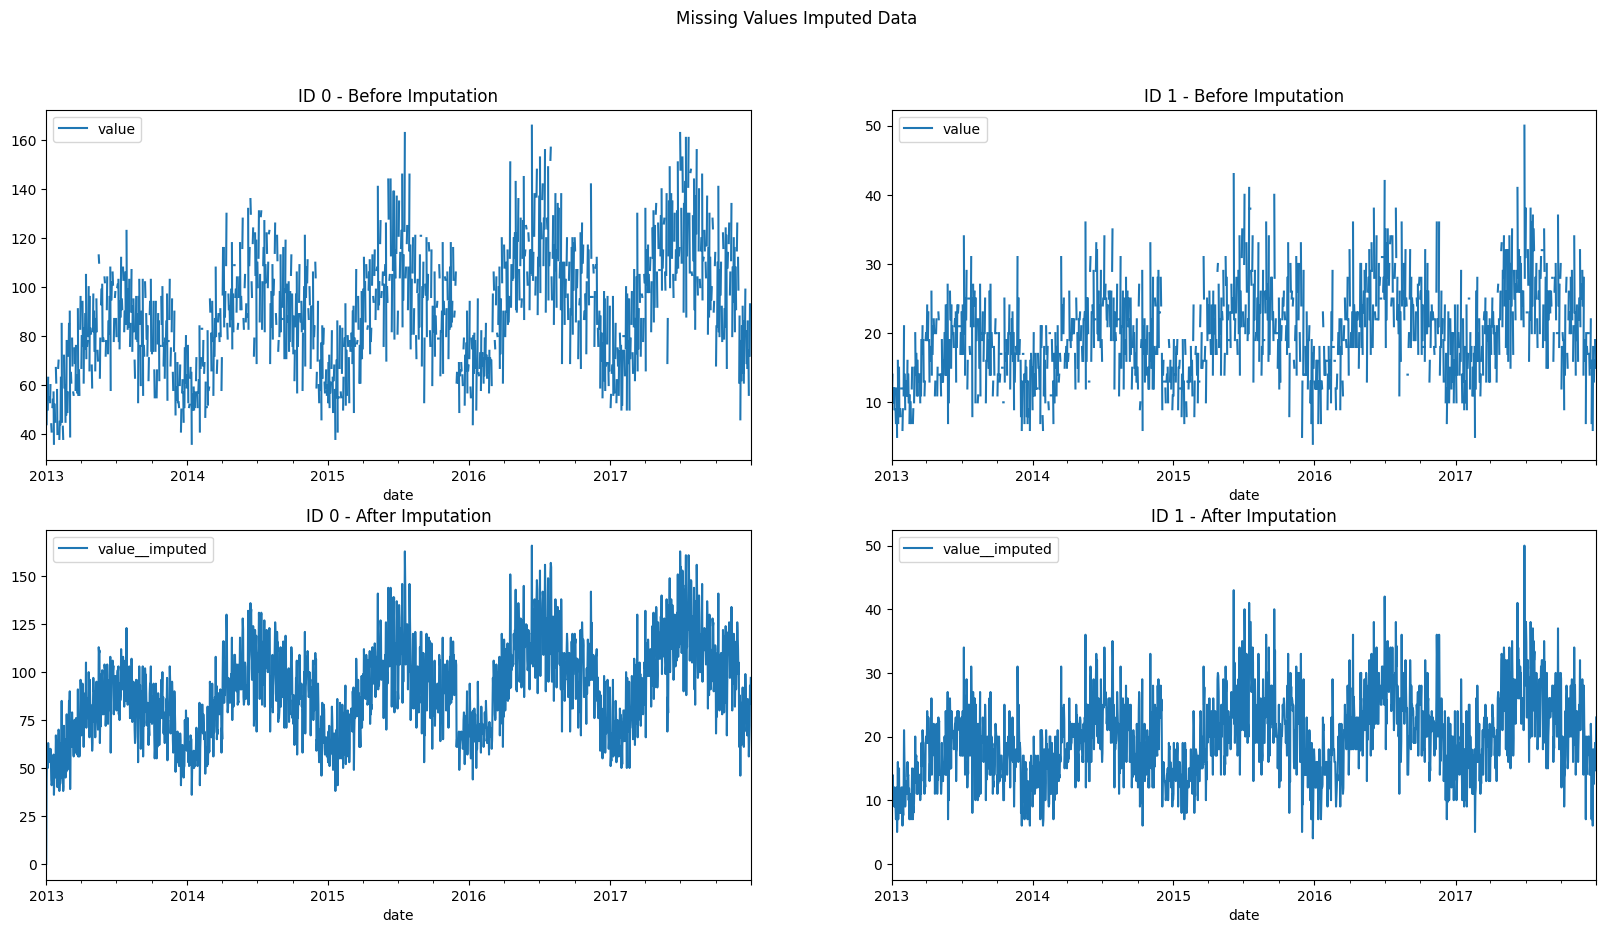

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Before imputation
data["raw_ts_X"][data["raw_ts_X"]["id"] == 0].plot(
    x=dataset.date_column, y=dataset.target_column, ax=ax[0, 0]
)
data["raw_ts_X"][data["raw_ts_X"]["id"] == 1].plot(
    x=dataset.date_column, y=dataset.target_column, ax=ax[0, 1]
)

# After imputation
data["raw_ts_X"][data["raw_ts_X"]["id"] == 0].plot(
    x=dataset.date_column, y=f"{dataset.target_column}__imputed", ax=ax[1, 0]
)
data["raw_ts_X"][data["raw_ts_X"]["id"] == 1].plot(
    x=dataset.date_column, y=f"{dataset.target_column}__imputed", ax=ax[1, 1]
)

plt.suptitle("Missing Values Imputed Data")
ax[0, 0].set_title("ID 0 - Before Imputation")
ax[0, 1].set_title("ID 1 - Before Imputation")
ax[1, 0].set_title("ID 0 - After Imputation")
ax[1, 1].set_title("ID 1 - After Imputation")

plt.legend()
plt.show()

## <a id='toc3_2_'></a>[Series2Features](#toc0_)

- These transformers are responsible for creating the feature matrix for the base model.
- During the feature matrix generation stage, they take the transformed data from the long series and convert it into specific features for the model.

### <a id='toc3_2_1_'></a>[LagTransformer & TargetGenerator](#toc0_)

`LagTransformer`: generates lags, which create time-shifted features.
- The lags in the `lags` parameter can be represented as an integer value (which generates a range(k)), or as a sequence of numbers. Lags that exceed the available history will be truncated (i.e., if the history length is 7, lags beyond 7 will not be generated).

For the target variable, it is important to apply the `TargetGenerator`, which generates targets for the model.

In [17]:
dataset_copy = deepcopy(dataset)
data = Pipeline.create_data_dict_for_pipeline(dataset_copy, features_idx, target_idx)

lag_transformer = LagTransformer(lags=[0, 1, 2])
target_generator = TargetGenerator()

data = lag_transformer.fit_transform(data, input_features=[dataset.target_column])
data = target_generator.fit_transform(data, input_features=[dataset.target_column])

# Now let's create features and target matrix 
data = lag_transformer.generate(data)
data = target_generator.generate(data)

print("raw_ts_X:")
print(data["raw_ts_X"][:15])

print("X after generating lags:")
print(data["X"][:5])

print("y after generating lags:")
print(data["y"][:5])

raw_ts_X:
         date   value  id
0  2013-01-01    48.0   0
1  2013-01-02    44.0   0
2  2013-01-03    60.0   0
3  2013-01-04    56.0   0
4  2013-01-05    50.0   0
5  2013-01-06    63.0   0
6  2013-01-07    27.0   0
7  2013-01-08    54.0   0
8  2013-01-09    55.0   0
9  2013-01-10    45.0   0
10 2013-01-11    53.0   0
11 2013-01-12    60.0   0
12 2013-01-13  7888.0   0
13 2013-01-14    44.0   0
14 2013-01-15    41.0   0
X after generating lags:
[[  54.   55.   45.]
 [  55.   45.   53.]
 [  45.   53.   60.]
 [  53.   60. 7888.]
 [  60. 7888.   44.]]
y after generating lags:
[[  53.   60. 7888.]
 [  60. 7888.   44.]
 [7888.   44.   41.]
 [  44.   41.   54.]
 [  41.   54.   51.]]


It is important to emphasize again that we set the history length to 10 and the forecasting horizon to 3. Therefore, the first row in X starts from the 7th point of the original time series.

## <a id='toc3_3_'></a>[Features2Features](#toc0_)

- These transformers work directly with the feature matrix generated by the previous transformers. They can make changes to the already existing feature matrix.

### <a id='toc3_3_1_'></a>[LastKnownNormalizer](#toc0_)

`LastKnownNormalizer`: normalization by subtracting or dividing lags based on the last known values.

- The **transform_features** and **transform_target** parameters allow independent control over the normalization of features and targets. It may be beneficial, in terms of model performance, to normalize only the features while keeping the targets in their original scale, or vice versa.
- The **regime** parameter defines the method of normalization (either we divide by the last known lag — **ratio**, or subtract the last known lag from all lags — **delta**).

In [18]:
last_known_delta = LastKnownNormalizer(
    transform_features=True,
    transform_target=True,
    regime="delta",
)

last_known_ratio = LastKnownNormalizer(
    transform_features=True,
    transform_target=False,
    regime="ratio",
)

data_lkn_delta = deepcopy(data)
data_lkn_ratio = deepcopy(data)

data_lkn_delta = last_known_delta.fit_transform(data_lkn_delta, input_features=lag_transformer.output_features)
data_lkn_ratio = last_known_ratio.fit_transform(data_lkn_ratio, input_features=lag_transformer.output_features)

print("X before last known normalization:")
print(data["X"][:5])

print("y before last known normalization:")
print(data["y"][:5])

data_lkn_delta = last_known_delta.generate(data_lkn_delta)
data_lkn_ratio = last_known_ratio.generate(data_lkn_ratio)

print("X after delta last known normalization:")
print(data_lkn_delta["X"][:5])

print("y after delta last known normalization:")
print(data_lkn_delta["y"][:5])

print("X after ratio last known normalization:")
print(data_lkn_ratio["X"][:5])

X before last known normalization:
[[  54.   55.   45.]
 [  55.   45.   53.]
 [  45.   53.   60.]
 [  53.   60. 7888.]
 [  60. 7888.   44.]]
y before last known normalization:
[[  53.   60. 7888.]
 [  60. 7888.   44.]
 [7888.   44.   41.]
 [  44.   41.   54.]
 [  41.   54.   51.]]
X after delta last known normalization:
[[ 9.000e+00  1.000e+01  0.000e+00]
 [ 2.000e+00 -8.000e+00  0.000e+00]
 [-1.500e+01 -7.000e+00  0.000e+00]
 [-7.835e+03 -7.828e+03  0.000e+00]
 [ 1.600e+01  7.844e+03  0.000e+00]]
y after delta last known normalization:
[[ 8.000e+00  1.500e+01  7.843e+03]
 [ 7.000e+00  7.835e+03 -9.000e+00]
 [ 7.828e+03 -1.600e+01 -1.900e+01]
 [-7.844e+03 -7.847e+03 -7.834e+03]
 [-3.000e+00  1.000e+01  7.000e+00]]
X after ratio last known normalization:
[[1.20000000e+00 1.22222222e+00 1.00000000e+00]
 [1.03773585e+00 8.49056604e-01 1.00000000e+00]
 [7.50000000e-01 8.83333333e-01 1.00000000e+00]
 [6.71906694e-03 7.60649087e-03 1.00000000e+00]
 [1.36363636e+00 1.79272727e+02 1.00000000e+

## <a id='toc3_4_'></a>[Sequential & Union](#toc0_)

`SequentialTransformer`:
- This transformer allows you to apply a sequence of transformers one after another. Each transformer in the sequence receives the output of the previous one as input.
- For example, you can first normalize the data using `StandardScalerTransformer`, and then generate lags using `LagTransformer`.

`UnionTransformer`:
- This transformer allows you to apply several transformers in parallel, after which their results, presented as a feature matrix (not a long series!), are combined.
- For example, you can apply several transformers at once, such as `DateSeasonsGenerator` for generating seasonal features and `OneHotEncodingTransformer` for encoding categorical features, and combine their results into a single table.

# <a id='toc4_'></a>[Pipeline](#toc0_)

After exploring the different types of transformers, we can combine them into a single chain using the `Pipeline` class. The `Pipeline` acts as a wrapper around the transformers and makes it easy to manage sequential or parallel data transformations using `SequentialTransformer` and `UnionTransformer`.

There are several ways to initialize the `Pipeline` class — let's go through them, from simple but less functional, to complex but more flexible.

So, there are two ways to build a pipline from transformers: initialise the transformers of interest by hand or use a config in the form of a dictionary. Let's look at both ways.

In [19]:
standard_scaler = StandardScalerTransformer(
    transform_features=True,
    transform_target=True
)

lag = LagTransformer(lags=3)
date_lag = LagTransformer(lags=3)
id_lag = LagTransformer(lags=1)

target_generator = TargetGenerator()

date_seasons = DateSeasonsGenerator(
    seasonalities=["doy", "m", "wd"],
    from_target_date=True,
)

In [20]:
union_1 = UnionTransformer(transformers_list=[lag, target_generator])

seq_1 = SequentialTransformer(transformers_list=[standard_scaler, union_1], input_features=["value"])
seq_2 = SequentialTransformer(transformers_list=[date_seasons, date_lag], input_features=["date"])
seq_3 = SequentialTransformer(transformers_list=[id_lag], input_features=["id"])

union = UnionTransformer(transformers_list=[seq_1, seq_2, seq_3])

In [21]:
pipeline_1 = Pipeline(union, multivariate=False)

In [22]:
pipeline_1.__dict__

{'transformers': <tsururu.transformers.base.UnionTransformer at 0x13ec64290>,
 'multivariate': False,
 'is_fitted': False,
 'strategy_name': None,
 'output_features': None,
 'y_original_shape': None,
 'features_sort_idx': None,
 'features_groups': None}

Or:

In [23]:
pipeline_params = {
    "target": {
        "columns": ["value"],
        "features": {
            "StandardScalerTransformer":
                {
                    "transform_target": True, 
                    "transform_features": True
                },
            "LagTransformer": {"lags": 7},
        },
    },
    "date": {
        "columns": ["date"],
        "features": {
            "DateSeasonsGenerator": {
                # Use seasonality features from the date column as 
                # features with datetime lags
                # Possible values: [
                #    "y": year, "m": month, "d": day, 
                #    "wd": weekday, "doy": dayofyear,
                #    "hour": hour, "min": minute, "sec": second, 
                #    "ms": microsecond,  "ns": nanosecond
                # ]
                "seasonalities": ['doy', 'm', 'wd'], 
                # Use date from target point to make datetime features
                "from_target_date": True,
            },
            "LagTransformer": {"lags": 3}
        },
    },
    "id": {
        "columns": ["id"],
        "features": {
            "LagTransformer": {"lags": 1},
        },
    }
}

In [24]:
pipeline = Pipeline.from_dict(pipeline_params, multivariate=False)

Or:

In [25]:
pipeline_easy_params = {
    "target_lags": 3,
    "date_lags": 1,
#    "exog_lags": 1,  # Uncomment this line if you have exogenous features
    # One from ["none", "standard_scaler", "difference_normalizer", "last_known_normalizer"]
    "target_normalizer": "standard_scaler",
    # One from ["none", "delta", "ratio"]  (MUST BE "none" for "standard_scaler" and NOT "none" for others)
    "target_normalizer_regime": "none",
}

In [26]:
pipeline = Pipeline.easy_setup(dataset_params, pipeline_easy_params, multivariate=False)

#### <a id='toc4_1_1_1_'></a>[Can I use exogenous variables in the pipeline?](#toc0_)

Yes! Exogenous variables can also be specified here. Just include them in your pipeline.

However, their operation is currently tested only for the `MIMOStrategy` in global-modelling. For other strategies support of additional variables is under development.

In [27]:
# pipeline_params["exog_group_1"] = {
#     "columns": ["value"],
#     "features": {
#         "StandardScalerTransformer":
#             {
#                 "transform_target": False, 
#                 "transform_features": True
#             },
#         "LagTransformer": {"lags": 7},
#     },
# }

__Make sure you have the transform_target = False flag for exogenous features!__